# Make HyperMapper solve Mnist

## Imports, yay

In [1]:
import pandas as pd
import math
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import time

#%matplotlib inline
#import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as Data

#tds
import torchvision

#git
#from __future__ import print_function
#import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import json

## Loads the MNIST data set

In [2]:
def get_mnist():
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=True, 
                                  download=True,
                                  transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size = 64, 
                                    shuffle=True)

    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=False, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size = 1000, shuffle=True)
    print('loaded the mnist data')
    return train_loader, test_loader

## Translates HyperMapper json to pyTorch module

In [3]:
# Same as in the nas notebook
class json2pheno(nn.Module):
    def __init__(self, json, nin, nout):
        super(json2pheno, self).__init__()
        # build layers from genome encoding

        n_in = nin
        fw_map = {}

        """vad jag har i json:
        n_nodes
        n_layers (räknar alla utom output)
        skip (hur långa skips vi gör, kan vara 0)
        """ 
        n_nodes = json['n_nodes']
        n_layers = json['n_layers']
        skip = json['skip']
        
        for i in range(n_layers):
            key = str(i)
            setattr(self, key, nn.Linear(n_in, n_nodes))
           
            # We are on the last hidden layer, so we will not have any skipps here
            if i == n_layers - 1:
                fw_map[key] = ['out']
                n_in = n_nodes
                break
            
            fw_map[key] = [str(i + 1)]
            
            # Add skips to the fw_map. If they are to long, sent them to output layer
            if skip:
                if i + skip + 1 < n_layers:
                    fw_map[key].append(str(i + skip + 1))
                else:
                    fw_map[key].append('out')

            
            # Again, this is same for all but first layer
            n_in = n_nodes

        setattr(self, 'out', nn.Linear(n_in, nout))

        # fw_scheme is a dict containing to which layers each layer is sending its output
        # This will fail if we have non-forward connections
        self.fw_scheme = fw_map
        print(self.fw_scheme)

    def forward(self, x):
        k = 0
        X = dict()
        X['0'] = [x.view(x.shape[0],-1)]
        while hasattr(self, str(k)):
            # pass trough all layers except the output layer
            key = str(k)

            # we might want to concat instead of sum, then we need to modify input_size in __init__
            temp_x = sum(X[key])
            temp_out = torch.tanh(getattr(self, key)(temp_x))
            # this seem to work when doing the list thing with x
            for target in self.fw_scheme[key]:
                if target in X:
                    X[target].append(temp_out)
                else:
                    X[target] = [temp_out]

            k += 1

        # if k = 0 we have no active layers and a perceptron model
        if k:
            temp_x = sum(X['out'])
        else:
            temp_x = x.view(x.shape[0],-1)

        # Identity as output function since we do regression
        # Add support for other types od problems problems
        out = getattr(self, 'out')(temp_x)
        return F.log_softmax(out, dim = 1)


## Create a json scenario

In [4]:
def create_scenario(doe, BO=0, output_path = "output_samples.csv"):
    scenario = {}
    scenario["application_name"] = "mnist"
    scenario["optimization_objectives"] = ["Value"]
    scenario["input_parameters"] = {}
    scenario["output_data_file"] = output_path
    scenario["design_of_experiment"] = {}

    # doe: nbr of random samples
    # BO: nbr op BO iters. BO = 0 means only random sampling
    scenario["optimization_iterations"] = BO
    scenario["design_of_experiment"]["doe_type"] = "random sampling"
    scenario["design_of_experiment"]["number_of_samples"] = doe


    n_nodes = {}
    n_nodes["parameter_type"] = "ordinal"
    n_nodes["values"] = [2**i for i in range(2, int(math.log(128, 2)) + 1)] # 16-128

    n_layers = {}
    n_layers["parameter_type"] = "integer"
    n_layers["values"] = [0, 2]

    skip = {}
    skip["parameter_type"] = "integer"
    skip["values"] = [0, 1]

    scenario["input_parameters"]["n_nodes"] = n_nodes
    scenario["input_parameters"]["n_layers"] = n_layers
    scenario["input_parameters"]["skip"] = skip

    %cd
    %cd "PycharmProjects/samuel_nas/my_hypermapper/example_scenarios/quick_start"
    with open("example_mnist_scenario.json", "w") as scenario_file:
        json.dump(scenario, scenario_file, indent=4)

    n_nodes["values"]

## Trains a network and returns validation performance

In [5]:
def trainer(network, train_data, test_data):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    t0 = time.perf_counter()
    for epoch in range(4):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            #running_loss += loss.item()
            #if i % 200 == 199:    # print every 200 mini-batches
             #   print('[%d, %5d] loss: %.3f' %
              #        (epoch + 1, i + 1, running_loss / 200))
               # running_loss = 0.0

    print('Finished Training it took ', (time.perf_counter() - t0)/60, ' minutes to train')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, labels = data
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print('Accuracy of the network on the 10000 test images: %d %%' % (
     #   100 * correct / total))
    # return error rate 
    return 1 - correct / total

## Objective function for hypermapper to optimize

In [6]:
def MNIST_function(X):
    """
    Compute the branin function.
    :param X: dictionary containing the input points.
    :return: the value of the branin function
    """
    # do not load each time
    train_loader, test_loader = get_mnist()

    nin = 28**2
    nout = 10

    my_net = json2pheno(X, nin, nout)

    loss = trainer(my_net, train_loader, test_loader)
    print(loss)
    return loss

## Basically the main method. Optimizes the given function based on the given scenario. 

### Stores the results in nas_output_samples.cvs

In [7]:
# fails to do many random samples. increase problem complexity
doe = 30
bo = 0
op = "mnist_RS_30.csv"
create_scenario(doe, BO=bo, output_path = op)

%cd
%cd "PycharmProjects/samuel_nas/my_hypermapper/scripts"

import hypermapper
%cd ".."
parameters_file = "example_scenarios/quick_start/example_mnist_scenario.json"
# parameters_file = "example_branin_scenario.json"
t_start = time.perf_counter()
hypermapper.optimize(parameters_file, MNIST_function)
print('this entire procedure took ', (time.perf_counter() - t_start) / 60, 'minutes')


/home/samuel
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper/example_scenarios/quick_start
/home/samuel
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper/scripts
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper

 ####
The Random sampling configuration selection will stop now. Is the search space very small?

Design of experiment phase, number of doe samples = 30 .......
loaded the mnist data
{}
Finished Training it took  0.9766110861998943  minutes to train
0.10199999999999998
loaded the mnist data
{}
Finished Training it took  0.965285011450275  minutes to train
0.13
loaded the mnist data
{'0': ['out']}


KeyboardInterrupt: 

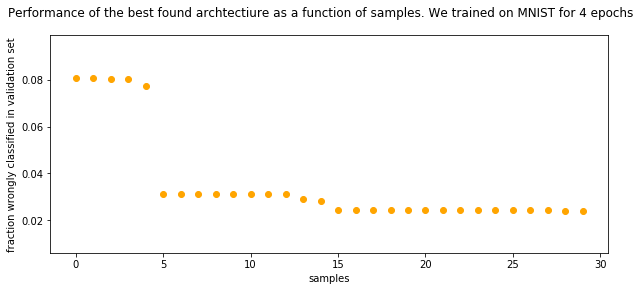

In [9]:
data = pd.read_csv ('mnist_BO_10+20.csv')   
data2 = pd.read_csv ('mnist_RS_30.csv')   

scores = np.zeros((len(data),2))
scores2 = np.zeros((len(data2),2))
scores[0, :] = [0, data['Value'].iloc[0]]
scores2[0, :] = [0, data2['Value'].iloc[0]]

for i in range(1, len(data)):
    scores[i, :] = [i, min(data['Value'].iloc[0:i])]
    if i < len(data2):
        scores2[i, :] = [i, min(data2['Value'].iloc[0:i])]
    
%matplotlib inline
import matplotlib.pyplot as plt

# view data
plt.figure(figsize=(10,4))

plt.scatter(scores[:,0], scores[:,1], color = "orange")
#plt.scatter(scores2[:,0], scores2[:,1], color = "blue")
#plt.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
plt.suptitle('Performance of the best found archtectiure as a function of samples. We trained on MNIST for 4 epochs')
plt.xlabel('samples')
plt.ylabel('fraction wrongly classified in validation set')
#plt.title('Regression Analysis')
#plt.text(1.0, 0, 'Loss = %.4f' % loss,
            #fontdict={'size': 24, 'color':  'red'})
plt.show()